In [65]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import filters
import cv2
from scipy.ndimage import gaussian_filter

import tensorflow as tf
from tensorflow.image import resize
import copy

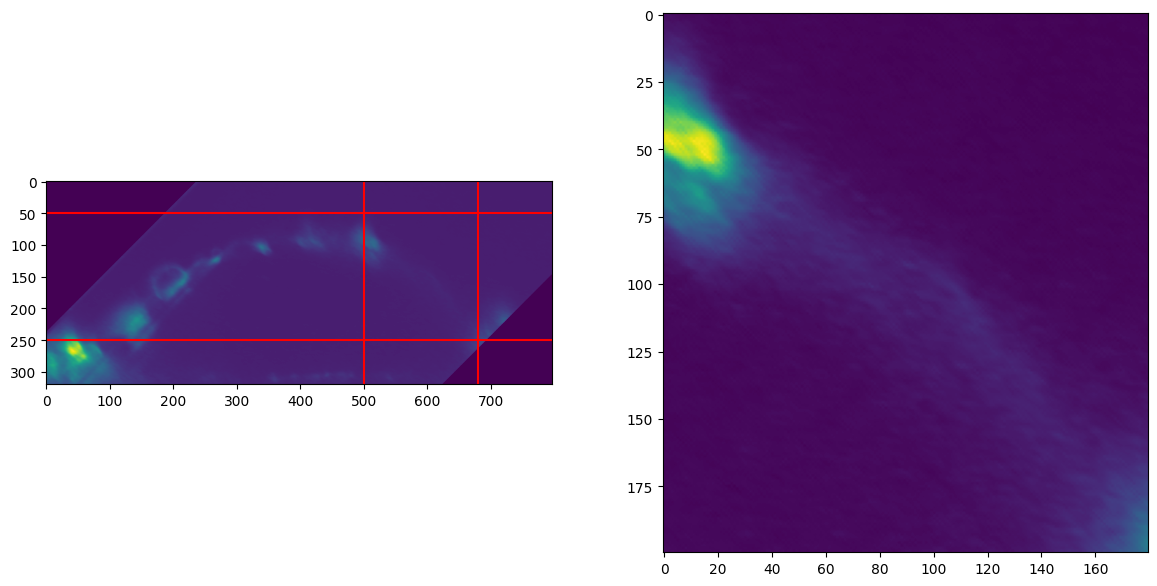

In [66]:
image = sk.io.imread('./domes/Dome103_processed_n2v2d.tif')
image = np.transpose(image, axes=(1, 0, 2))

# viewer = napari.Viewer()
# viewer.add_image(image)
# alpha = 1  # Adjust this value to change contrast
# beta = 1   # Adjust this value to change brightness
# image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
# viewer.add_image(image)

z = 300

y1, y2 = 50, 250
x1, x2 = 500, 680

plt.figure(figsize=(30,7))

plt.subplot(1,4,1)
plt.imshow(image[z])
plt.axhline(y1, c='r')
plt.axhline(y2, c='r')
plt.axvline(x1, c='r')
plt.axvline(x2, c='r')

plt.subplot(1,4,2)
plt.imshow(image[z, y1:y2, x1:x2])

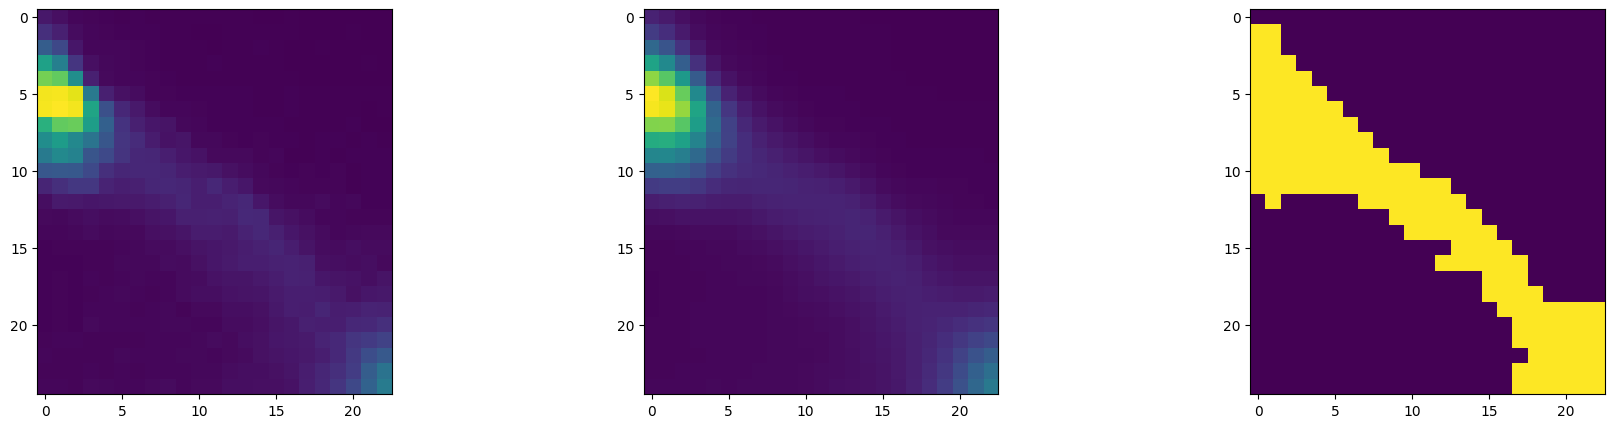

In [67]:
im = image[z, y1:y2, x1:x2]

pool_size = (2, 2)
pooled_image = sk.measure.block_reduce(im, pool_size, func=np.max)
pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)
pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)
# pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)
# pooled_image = sk.measure.block_reduce(pooled_image, pool_size, func=np.max)

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(pooled_image)


plt.subplot(1,4,2)
pooled_image_g = gaussian_filter(pooled_image, sigma=1)
plt.imshow(pooled_image_g)


plt.subplot(1,4,3)
mean =  pooled_image.mean()
pooled_mask = copy.copy(pooled_image)
pooled_mask[pooled_image > mean] = 255
pooled_mask[pooled_image <= mean] = 0

plt.imshow(pooled_mask)

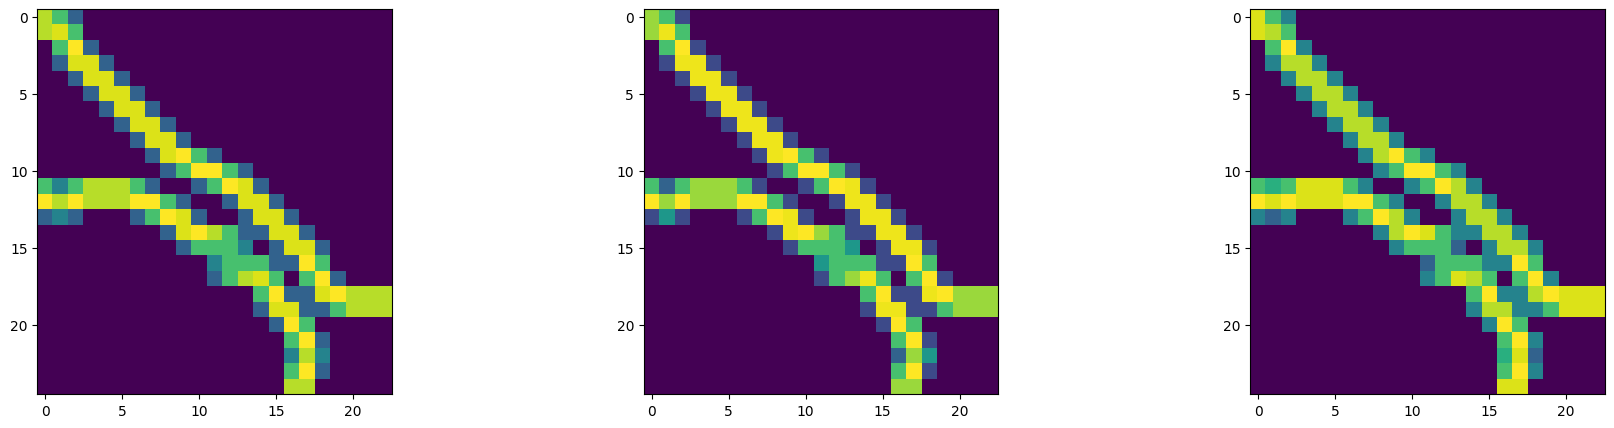

In [68]:
edge_sobel = filters.sobel(pooled_mask)
edge_scharr = filters.scharr(pooled_mask)
edge_prewitt = filters.prewitt(pooled_mask)

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(edge_sobel)
plt.subplot(1,4,2)
plt.imshow(edge_scharr)
plt.subplot(1,4,3)
plt.imshow(edge_prewitt)

In [101]:
# Load your max-pooled image data from a NumPy array (assuming it's uint32)
max_pooled_image_data = pooled_mask  # Replace 'your_numpy_array' with your actual data

# Define the upsampling factor
upsampling_factor = 2  # If you want to restore the original size, set it to 2^3 = 8

# Calculate the dimensions of the original image
original_height = max_pooled_image_data.shape[0] * upsampling_factor**3
original_width = max_pooled_image_data.shape[1] * upsampling_factor**3

# Create a transposed convolution layer in TensorFlow
# Adjust the kernel size and strides as needed
deconv_layer = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='linear')

# Reshape the max-pooled image data for convolution
max_pooled_image_data = max_pooled_image_data.reshape((1,) + max_pooled_image_data.shape + (1,))  # Add batch and channel dimensions

# Convert the NumPy array to a TensorFlow tensor
max_pooled_image_tensor = tf.convert_to_tensor(max_pooled_image_data, dtype=tf.float32)

# Apply transposed convolution to upsample the image
upsampled_image = deconv_layer(max_pooled_image_tensor)

# Remove the batch and channel dimensions
upsampled_image = tf.squeeze(upsampled_image, axis=0)
upsampled_image = tf.squeeze(upsampled_image, axis=-1)

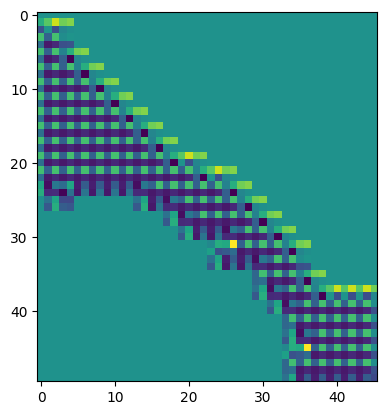

In [102]:
upsampled_image.shape

plt.imshow(upsampled_image.numpy())